In [244]:
# Final Project - NHANES 2013-2014 Age Group Classification: Age & Diabetes
# Data Mining & Text Analytics - MATH 3310 - Fall 2025

# This script:
#   - Loads a prepared NHANES 2013–2014 subset (CSV)
#   - Performs basic data checks and exploratory data analysis
#   - Builds preprocessing + modeling pipelines with ColumnTransformer
#   - Task 1: Age-group classification (Teen vs Adult)
#       * Baseline Logistic Regression vs Random Forest classifier model comparison
#       * Hyperparameter tuning with GridSearchCV for Random Forest since it outperformed LR
#       * Stratified 5-fold cross-validation
#       * Comparison of metrics and simple feature interpretation
#   - Task 2: Diabetes-risk classification (binary label from DIQ010)
#       * Baseline Logistic Regression and Random Forest
#       * Grid search over RF hyperparameters
#       * Cross-validation strategy comparison (StratifiedKFold vs KFold)
#       * Class-weighted Random Forest models
#       * SMOTE + Random undersampling + Random Forest
#       * Summary table of accuracy, error rate, balanced accuracy, F1, G-mean
#       * Feature importance (MDI, permutation, optional SHAP)
#   - Contains a written reflection / discussion block (for report) at the end

In [304]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score as gmean_score

In [246]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, target_name=""):
    """
    Fit a classifier, evaluate on test, and print metrics.
    Returns (y_test_pred, metrics_dict).
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # For ROC-AUC, need predicted probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_prob)
    else:
        roc = np.nan

    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    gm = gmean_score(y_test, y_pred)

    print(f"=== {target_name} — Test Set Metrics ===")
    print(f"Accuracy:           {acc:.4f}")
    print(f"Balanced accuracy:  {bal_acc:.4f}")
    print(f"F1 score (pos=1):   {f1:.4f}")
    print(f"G-mean:             {gm:.4f}")
    if not np.isnan(roc):
        print(f"ROC-AUC:            {roc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred), "\n")

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
    plt.title(f"{target_name} — Confusion Matrix (Test)")
    plt.tight_layout()
    plt.show()

    metrics = {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "f1": f1,
        "gmean": gm,
        "roc_auc": roc,
    }
    return y_pred, metrics

In [247]:
# Read file

# Define the relative path to the CSV file
file_path = '..\\data\\raw\\NHANES_age_prediction.csv'

# Read the CSV file into a DataFrame
try:
    df = pd.read_csv(file_path)
    print(df.head())
except Exception as e:
    print(f"An error occurred: {e}")

      SEQN age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  \
0  73564.0     Adult      61.0       2.0     2.0    35.7   110.0     2.0   
1  73568.0     Adult      26.0       2.0     2.0    20.3    89.0     2.0   
2  73576.0     Adult      16.0       1.0     2.0    23.2    89.0     2.0   
3  73577.0     Adult      32.0       1.0     2.0    28.9   104.0     2.0   
4  73580.0     Adult      38.0       2.0     1.0    35.9   103.0     2.0   

   LBXGLT  LBXIN  
0   150.0  14.91  
1    80.0   3.85  
2    68.0   6.14  
3    84.0  16.15  
4    81.0  10.92  


In [248]:
# Display information about the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6   LBXGLU     2278 non-null   float64
 7   DIQ010     2278 non-null   float64
 8   LBXGLT     2278 non-null   float64
 9   LBXIN      2278 non-null   float64
dtypes: float64(9), object(1)
memory usage: 178.1+ KB
None


In [249]:
# Rename columns for clarity and check for missing values

df.rename(columns={
    'SEQN': 'ID',
    'RIDAGEYR': 'Age',
    'RIAGENDR': 'Gender',
    'PAQ605': 'Physical_Activity',
    'BMXBMI': 'BMI',
    'LBXGLU': 'Glucose_Level',
    'DIQ010': 'Diabetes_Status',
    'LBXGLT': 'Oral_Glucose_Test',
    'LBXIN': 'Insulin_Level'}, inplace=True)


print(df.isnull().sum())
print(f'Age Group            {df['age_group'].isnull().sum()}')

ID                   0
age_group            0
Age                  0
Gender               0
Physical_Activity    0
BMI                  0
Glucose_Level        0
Diabetes_Status      0
Oral_Glucose_Test    0
Insulin_Level        0
dtype: int64
Age Group            0


In [250]:
# Split the data into features and target variable
X_agegroup = df.drop(columns=['age_group'])
y_agegroup = df['age_group']

In [251]:
# check for impossible negative values
(X_agegroup < 0).sum()

ID                   0
Age                  0
Gender               0
Physical_Activity    0
BMI                  0
Glucose_Level        0
Diabetes_Status      0
Oral_Glucose_Test    0
Insulin_Level        0
dtype: int64

In [252]:
# change the physical activity where it is 7 to a 2 because 7 must have been a mistake
X_agegroup['Physical_Activity'] = X_agegroup['Physical_Activity'].replace(7, 2)
X_agegroup.drop(columns=['ID', 'Age'], inplace=True)

# drop ID because it has no predictive power, age is represented in the target variable

# get description of data
print(X_agegroup.describe())

            Gender  Physical_Activity          BMI  Glucose_Level  \
count  2278.000000        2278.000000  2278.000000    2278.000000   
mean      1.511414           1.820457    27.955180      99.553117   
std       0.499979           0.383891     7.248962      17.889834   
min       1.000000           1.000000    14.500000      63.000000   
25%       1.000000           2.000000    22.800000      91.000000   
50%       2.000000           2.000000    26.800000      97.000000   
75%       2.000000           2.000000    31.200000     104.000000   
max       2.000000           2.000000    70.100000     405.000000   

       Diabetes_Status  Oral_Glucose_Test  Insulin_Level  
count      2278.000000        2278.000000    2278.000000  
mean          2.016242         114.978929      11.834794  
std           0.185556          47.061239       9.718812  
min           1.000000          40.000000       0.140000  
25%           2.000000          87.000000       5.860000  
50%           2.000000  

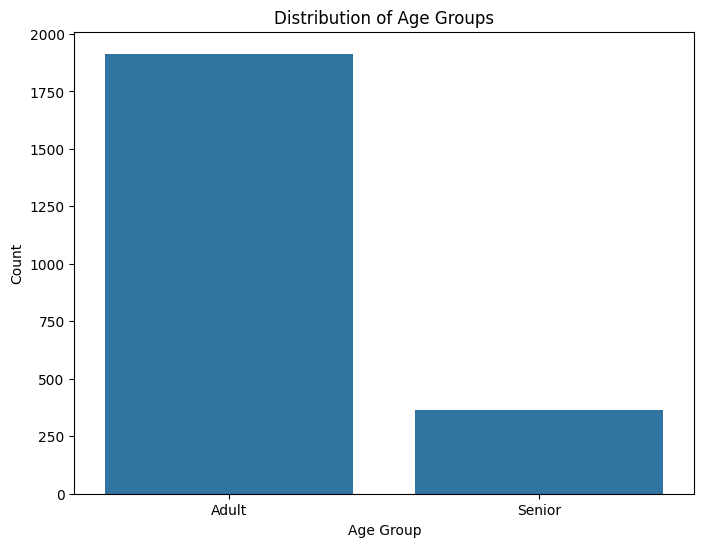

In [253]:
# graph the target variable to test for imbalance

plt.figure(figsize=(8, 6))
sns.countplot(x=y_agegroup)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

In [254]:
# this is pretty unbalanced so we will have to stratify when we split the data later!
# split the data into training and testing sets with stratification

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_agegroup, y_agegroup, test_size=0.2, stratify=y_agegroup, random_state=1001)
print("Training set class distribution:")
print(y_train_age.value_counts(normalize=True))
print("\nTesting set class distribution:")
print(y_test_age.value_counts(normalize=True))

Training set class distribution:
age_group
Adult     0.840285
Senior    0.159715
Name: proportion, dtype: float64

Testing set class distribution:
age_group
Adult     0.839912
Senior    0.160088
Name: proportion, dtype: float64


In [255]:
# prepare lists of numerical and categorical features for pipeline
age_numerical_features = X_agegroup.select_dtypes(include=['int64', 'float64']).columns.tolist()
age_categorical_features = X_agegroup.select_dtypes(include=['object', 'category']).columns.tolist()

In [256]:
feature_selector = SelectFromModel(
    RandomForestClassifier(
        n_estimators=300,
        random_state=1001
    ),
    threshold="median"   
)

In [257]:
# define preprocessing pipelines for numerical and categorical data

age_numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))
])
age_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
age_preprocessor = ColumnTransformer(
    transformers=[
        ("num", age_numerical_transformer, age_numerical_features),
        ("cat", age_categorical_transformer, age_categorical_features),
    ]
)
age_preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [258]:
# Baseline Logistic Regression model for Age Group classification

age_pipe = Pipeline(steps=[
    ('preprocessor', age_preprocessor),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=927), threshold='median')),
    ('classifier', RandomForestClassifier(n_estimators=500, random_state=927))
])
age_pipe.fit(X_train_age, y_train_age)

,steps,"[('preprocessor', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [259]:
param_grid_age = [
    {
        'classifier': [LogisticRegression(max_iter=2000, solver="liblinear")],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    {
        'classifier': [RandomForestClassifier(random_state=0)],
        'classifier__n_estimators': [100, 300, 500,1000]
    }
]

In [260]:
# apply grid search

kf_age = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)
gs_age = GridSearchCV(age_pipe, param_grid_age, cv=kf_age, scoring='balanced_accuracy')

In [261]:
gs_age.fit(X_train_age, y_train_age)

,estimator,Pipeline(step..._state=927))])
,param_grid,"[{'classifier': [LogisticRegre...r='liblinear')], 'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l2']}, {'classifier': [RandomForestC...andom_state=0)], 'classifier__n_estimators': [100, 300, ...]}]"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [262]:
print(f' Best Parameters: {gs_age.best_params_}')
print(f'Best Score: {gs_age.best_score_:.4f}')
best_model_age = gs_age.best_estimator_


 Best Parameters: {'classifier': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 100}
Best Score: 0.5826


In [263]:
# stratified 5-fold cross-validation for Random Forest on Age Group classification

cv_scores_age = cross_val_score(
    best_model_age,
    X_train_age,
    y_train_age,
    cv=5,
    scoring="balanced_accuracy"
)

print(cv_scores_age)
print("Mean CV balanced accuracy for Logistic Regression Model on Age Group Classification:", cv_scores_age.mean())

[0.54655478 0.5839043  0.55961235 0.54563895 0.59944783]
Mean CV balanced accuracy for Logistic Regression Model on Age Group Classification: 0.5670316406105108


In [265]:
# define imbalanced pipeline

imb_pipe_age = ImbPipeline(steps=[('preprocessor', age_preprocessor),
                ('oversample', SMOTE()),
                ('undersample', RandomUnderSampler(random_state=42)),  
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [266]:
imb_gs_age = GridSearchCV(imb_pipe_age, param_grid_age, cv=kf_age, scoring='balanced_accuracy')
imb_gs_age.fit(X_train_age, y_train_age)

,estimator,Pipeline(step...om_state=0))])
,param_grid,"[{'classifier': [LogisticRegre...r='liblinear')], 'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l2']}, {'classifier': [RandomForestC...andom_state=0)], 'classifier__n_estimators': [100, 300, ...]}]"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [267]:
print(f' Best Parameters: {gs_age.best_params_}')
print(f'Best Score: {gs_age.best_score_:.4f}')
best_model_age = gs_age.best_estimator_

 Best Parameters: {'classifier': RandomForestClassifier(random_state=0), 'classifier__n_estimators': 100}
Best Score: 0.5826


In [268]:
cv_scores_age = cross_val_score(
    best_model_age,
    X_train_age,
    y_train_age,
    cv=5,
    scoring="balanced_accuracy"
)

print(cv_scores_age)
print("Mean CV balanced accuracy for Random Forest Classifier Model on Age Group Classification:", cv_scores_age.mean())

[0.54655478 0.5839043  0.55961235 0.54563895 0.59944783]
Mean CV balanced accuracy for Random Forest Classifier Model on Age Group Classification: 0.5670316406105108


=== Age-group: Random Forest (Stratified 5-fold CV) ===
Mean CV balanced accuracy: 0.5826
Std CV balanced accuracy:  0.0213
Fold scores: [0.58208707 0.60440301 0.59364435 0.59037638 0.54237097] 

=== Age-group (Random Forest) — Test Set Metrics ===
Accuracy:           0.8311
Balanced accuracy:  0.5447
F1 score (pos=1):   0.5476
G-mean:             0.3451
ROC-AUC:            0.7027

Classification report:
              precision    recall  f1-score   support

       Adult       0.85      0.97      0.91       383
      Senior       0.41      0.12      0.19        73

    accuracy                           0.83       456
   macro avg       0.63      0.54      0.55       456
weighted avg       0.78      0.83      0.79       456

Confusion matrix:
[[370  13]
 [ 64   9]] 



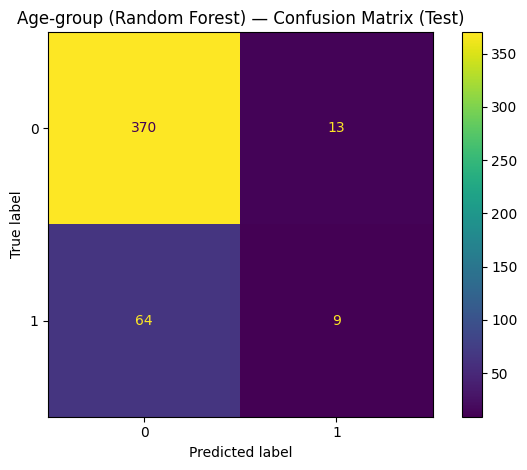

In [269]:
cv_scores_age = cross_val_score(
    best_model_age,
    X_train_age,
    y_train_age,
    cv=kf_age,
    scoring="balanced_accuracy",
    n_jobs=-1,
)

print("=== Age-group: Random Forest (Stratified 5-fold CV) ===")
print(f"Mean CV balanced accuracy: {cv_scores_age.mean():.4f}")
print(f"Std CV balanced accuracy:  {cv_scores_age.std():.4f}")
print("Fold scores:", cv_scores_age, "\n")

y_age_pred_rf, age_rf_metrics = evaluate_classifier(
    best_model_age,
    X_train_age,
    X_test_age,
    y_train_age,
    y_test_age,
    target_name="Age-group (Random Forest)",
)

In [270]:
# 1 means yes, 2 means no, 3 means borderline, 7 and 9 means refused/don't know
# we will change 'yes' and 'borderline' to 1 (has diabetes or at risk), and 'no' to 0 (no diabetes)

diab_df = df[df["Diabetes_Status"].isin([1, 2, 3])].copy()
diab_df["diabetes_binary"] = diab_df["Diabetes_Status"].map({1: 1, 2: 0, 3: 1}).astype(int)

print("Diabetes_binary value counts:")
print(diab_df["diabetes_binary"].value_counts(), "\n")
print("Class proportions (diabetes_binary):")
print(diab_df["diabetes_binary"].value_counts(normalize=True), "\n")

Diabetes_binary value counts:
diabetes_binary
0    2199
1      79
Name: count, dtype: int64 

Class proportions (diabetes_binary):
diabetes_binary
0    0.96532
1    0.03468
Name: proportion, dtype: float64 



In [273]:
# Task 2: Diabetes-risk classification (binary label from Diabetes Status)
# we are going to focus on age, sex, BMI, glucose-related features, and vigorous exercise

X_diab = diab_df.drop(columns=['Diabetes_Status', 'diabetes_binary', 'ID', 'age_group', 'Insulin_Level'])
y_diab = diab_df['diabetes_binary']

In [274]:
X_diab.head()

,Age,Gender,Physical_Activity,BMI,Glucose_Level,Oral_Glucose_Test
0,61.0,2.0,2.0,35.7,110.0,150.0
1,26.0,2.0,2.0,20.3,89.0,80.0
2,16.0,1.0,2.0,23.2,89.0,68.0
3,32.0,1.0,2.0,28.9,104.0,84.0
4,38.0,2.0,1.0,35.9,103.0,81.0


In [278]:
# train/test split the data

X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(X_diab, y_diab, test_size=0.2, stratify=y_diab, random_state=1117)
print("Training set class distribution:")
print(y_train_diab.value_counts(normalize=True))
print("\nTesting set class distribution:")
print(y_test_diab.value_counts(normalize=True))

Training set class distribution:
diabetes_binary
0    0.965423
1    0.034577
Name: proportion, dtype: float64

Testing set class distribution:
diabetes_binary
0    0.964912
1    0.035088
Name: proportion, dtype: float64


In [282]:
# clarify numerical and categorical data

diab_numerical_features = X_diab.select_dtypes(include=["int64", "float64"]).columns.tolist()
diab_categorical_features = X_diab.select_dtypes(include=["object", "category"]).columns.tolist()

print("Diabetes numeric features:", diab_numerical_features)
print("Diabetes categorical features:", diab_categorical_features, "\n")

Diabetes numeric features: ['Age', 'Gender', 'Physical_Activity', 'BMI', 'Glucose_Level', 'Oral_Glucose_Test']
Diabetes categorical features: [] 



In [288]:
# create preprocessing pipelines for numerical and categorical data

diab_numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
diab_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
diab_preprocessor = ColumnTransformer(
    transformers=[
        ("num", diab_numerical_transformer, diab_numerical_features),
        ("cat", diab_categorical_transformer, diab_categorical_features),
    ]
)
cv_strat_diab = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

diab_preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [ ]:
# fit the pipeline

diab_pipe = Pipeline(steps=[
    ('preprocessor', diab_preprocessor),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=927), threshold='median')),
    ('classifier', RandomForestClassifier(n_estimators=500, random_state=927))
])
diab_pipe.fit(X_train_diab, y_train_diab)

,steps,"[('preprocessor', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [286]:
# baseline  logistic regression and random forest models for diabetes classification

log_reg_diab = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
)
diab_log_pipe = Pipeline(
    steps=[
        ("preprocessor", diab_preprocessor),
        ("classifier", log_reg_diab),
    ]
)
rf_diab = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)
diab_rf_pipe = Pipeline(
    steps=[
        ("preprocessor", diab_preprocessor),
        ("classifier", rf_diab),
    ]
)

In [289]:
# CV for baseline Logistic Regression

log_cv_scores_diab = cross_val_score(
    diab_log_pipe,
    X_train_diab,
    y_train_diab,
    cv=cv_strat_diab,
    scoring="balanced_accuracy"
)

print("=== Diabetes: Baseline Logistic Regression (Stratified 5-fold CV) ===")
print(f"Mean CV balanced accuracy: {log_cv_scores_diab.mean():.4f}")
print(f"Std CV balanced accuracy:  {log_cv_scores_diab.std():.4f}")
print("Fold scores:", log_cv_scores_diab, "\n")

=== Diabetes: Baseline Logistic Regression (Stratified 5-fold CV) ===
Mean CV balanced accuracy: 0.5223
Std CV balanced accuracy:  0.0315
Fold scores: [0.49715909 0.49857955 0.54166667 0.49857955 0.57549858] 



In [290]:
# CV for baseline Random Forest

rf_cv_scores_diab = cross_val_score(
    diab_rf_pipe,
    X_train_diab,
    y_train_diab,
    cv=cv_strat_diab,
    scoring="balanced_accuracy",
    n_jobs=-1,
)

print("=== Diabetes: Baseline Random Forest (Stratified 5-fold CV) ===")
print(f"Mean CV balanced accuracy: {rf_cv_scores_diab.mean():.4f}")
print(f"Std CV balanced accuracy:  {rf_cv_scores_diab.std():.4f}")
print("Fold scores:", rf_cv_scores_diab, "\n")

=== Diabetes: Baseline Random Forest (Stratified 5-fold CV) ===
Mean CV balanced accuracy: 0.5223
Std CV balanced accuracy:  0.0322
Fold scores: [0.49573864 0.49715909 0.5        0.54166667 0.57692308] 



=== Diabetes (Logistic Regression) — Test Set Metrics ===
Accuracy:           0.9627
Balanced accuracy:  0.4989
F1 score (pos=1):   0.4905
G-mean:             0.0000
ROC-AUC:            0.7463

Classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       440
           1       0.00      0.00      0.00        16

    accuracy                           0.96       456
   macro avg       0.48      0.50      0.49       456
weighted avg       0.93      0.96      0.95       456

Confusion matrix:
[[439   1]
 [ 16   0]] 



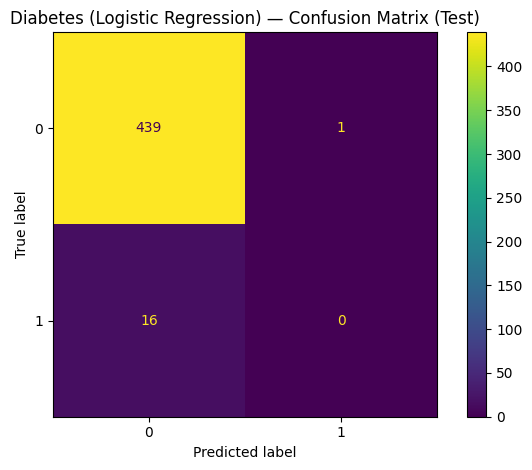

=== Diabetes (Random Forest, baseline) — Test Set Metrics ===
Accuracy:           0.9627
Balanced accuracy:  0.4989
F1 score (pos=1):   0.4905
G-mean:             0.0000
ROC-AUC:            0.6633

Classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       440
           1       0.00      0.00      0.00        16

    accuracy                           0.96       456
   macro avg       0.48      0.50      0.49       456
weighted avg       0.93      0.96      0.95       456

Confusion matrix:
[[439   1]
 [ 16   0]] 



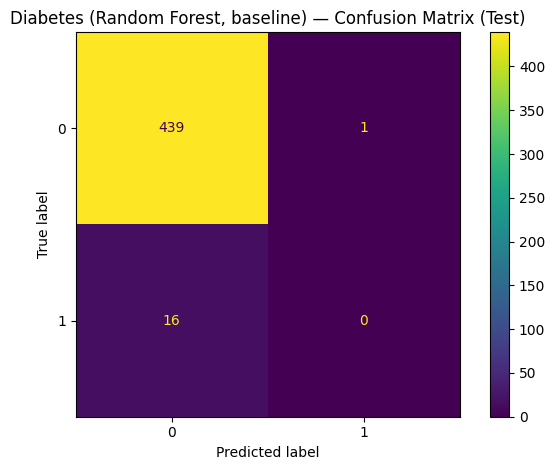

In [291]:
# Evaluate model on test set

y_diab_pred_log, diab_log_metrics = evaluate_classifier(
    diab_log_pipe,
    X_train_diab,
    X_test_diab,
    y_train_diab,
    y_test_diab,
    target_name="Diabetes (Logistic Regression)",
)

y_diab_pred_rf, diab_rf_metrics = evaluate_classifier(
    diab_rf_pipe,
    X_train_diab,
    X_test_diab,
    y_train_diab,
    y_test_diab,
    target_name="Diabetes (Random Forest, baseline)",
)


In [293]:
# grid search over RF Hyperparameters

rf_grid_pipe = Pipeline(
    steps=[
        ("preprocessor", diab_preprocessor),
        ("classifier", RandomForestClassifier(random_state=0, n_jobs=-1)),
    ]
)

param_grid_diab = {
    "classifier__n_estimators": [200, 400, 800],
    "classifier__max_depth": [None, 5, 10],
}

gs_diab = GridSearchCV(
    estimator=rf_grid_pipe,
    param_grid=param_grid_diab,
    cv=cv_strat_diab,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1,
)

gs_diab.fit(X_train_diab, y_train_diab)

print("\nBest parameters from GridSearch (diabetes RF):")
print(gs_diab.best_params_)
print(f"Best mean CV balanced accuracy: {gs_diab.best_score_:.4f}\n")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters from GridSearch (diabetes RF):
{'classifier__max_depth': 10, 'classifier__n_estimators': 400}
Best mean CV balanced accuracy: 0.5152



=== Diabetes (Random Forest, tuned) — Test Set Metrics ===
Accuracy:           0.9627
Balanced accuracy:  0.4989
F1 score (pos=1):   0.4905
G-mean:             0.0000
ROC-AUC:            0.6943

Classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       440
           1       0.00      0.00      0.00        16

    accuracy                           0.96       456
   macro avg       0.48      0.50      0.49       456
weighted avg       0.93      0.96      0.95       456

Confusion matrix:
[[439   1]
 [ 16   0]] 



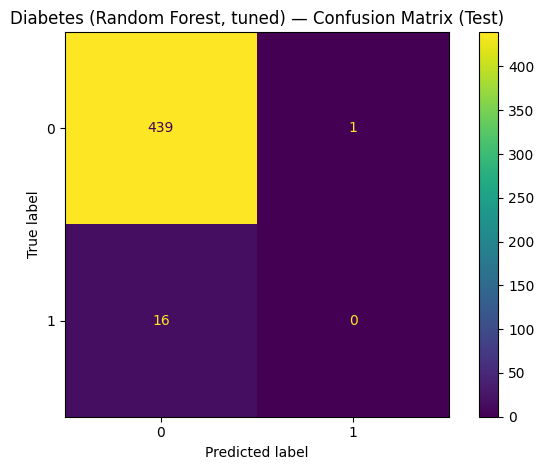

In [294]:
best_diab_rf_pipe = gs_diab.best_estimator_

y_diab_pred_gs, diab_gs_metrics = evaluate_classifier(
    best_diab_rf_pipe,
    X_train_diab,
    X_test_diab,
    y_train_diab,
    y_test_diab,
    target_name="Diabetes (Random Forest, tuned)",
)

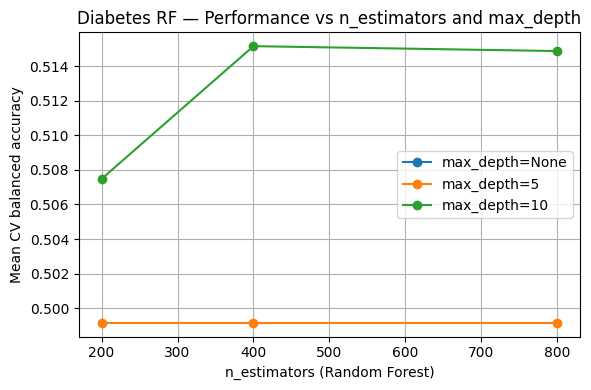

In [298]:
# visualize RF performance vs hyperparameters

results_diab = pd.DataFrame(gs_diab.cv_results_)

plt.figure(figsize=(6, 4))
for depth in results_diab["param_classifier__max_depth"].unique():
    mask = results_diab["param_classifier__max_depth"] == depth
    subset = results_diab[mask]
    plt.plot(
        subset["param_classifier__n_estimators"],
        subset["mean_test_score"],
        marker="o",
        label=f"max_depth={depth}",
    )

plt.xlabel("n_estimators (Random Forest)")
plt.ylabel("Mean CV balanced accuracy")
plt.title("Diabetes RF — Performance vs n_estimators and max_depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [297]:
# cv strategy comparison (StratifiedKFold vs KFold)

kf_42 = KFold(n_splits=5, shuffle=True, random_state=42)
kf_99 = KFold(n_splits=5, shuffle=True, random_state=99)

gs_diab_kf_42 = GridSearchCV(
    estimator=rf_grid_pipe,
    param_grid=param_grid_diab,
    cv=kf_42,
    scoring="balanced_accuracy",
    n_jobs=-1,
)
gs_diab_kf_42.fit(X_train_diab, y_train_diab)

gs_diab_kf_99 = GridSearchCV(
    estimator=rf_grid_pipe,
    param_grid=param_grid_diab,
    cv=kf_99,
    scoring="balanced_accuracy",
    n_jobs=-1,
)
gs_diab_kf_99.fit(X_train_diab, y_train_diab)

print("Best params with StratifiedKFold :", gs_diab.best_params_)
print("Best params with KFold (seed 42):", gs_diab_kf_42.best_params_)
print("Best params with KFold (seed 99):", gs_diab_kf_99.best_params_, "\n")


Best params with StratifiedKFold : {'classifier__max_depth': 10, 'classifier__n_estimators': 400}
Best params with KFold (seed 42): {'classifier__max_depth': None, 'classifier__n_estimators': 800}
Best params with KFold (seed 99): {'classifier__max_depth': None, 'classifier__n_estimators': 800} 



In [299]:
imb_pipe_diab = ImbPipeline(
    steps=[
        ("preprocessor", diab_preprocessor),
        ("oversample", SMOTE(random_state=42)),
        ("undersample", RandomUnderSampler(random_state=42)),
        (
            "classifier",
            RandomForestClassifier(
                n_estimators=300,
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

In [301]:
scores_imb_diab = cross_val_score(
    imb_pipe_diab,
    X_train_diab,
    y_train_diab,
    cv=cv_strat_diab,
    scoring="balanced_accuracy",
    n_jobs=-1,
)

print(
    "SMOTE + RandomUnderSampler – Stratified 5-fold balanced accuracy:"
    " mean={:.4f}, std={:.4f}".format(scores_imb_diab.mean(), scores_imb_diab.std())
)

SMOTE + RandomUnderSampler – Stratified 5-fold balanced accuracy: mean=0.6006, std=0.0436


In [305]:
y_oof_imb_diab = cross_val_predict(
    imb_pipe_diab,
    X_train_diab,
    y_train_diab,
    cv=cv_strat_diab,
    n_jobs=-1,
)

print("\nSMOTE + RandomUnderSampler – aggregated classification report (train CV):")
print(classification_report(y_train_diab, y_oof_imb_diab))
print("SMOTE + RandomUnderSampler – confusion matrix (train CV):")
print(confusion_matrix(y_train_diab, y_oof_imb_diab))



SMOTE + RandomUnderSampler – aggregated classification report (train CV):
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1759
           1       0.12      0.27      0.17        63

    accuracy                           0.91      1822
   macro avg       0.55      0.60      0.56      1822
weighted avg       0.94      0.91      0.92      1822

SMOTE + RandomUnderSampler – confusion matrix (train CV):
[[1637  122]
 [  46   17]]


In [306]:
imb_pipe_diab.fit(X_train_diab, y_train_diab)
y_diab_test_imb = imb_pipe_diab.predict(X_test_diab)

print("\nSMOTE + RandomUnderSampler – test classification report:")
print(classification_report(y_test_diab, y_diab_test_imb))
print("SMOTE + RandomUnderSampler – test confusion matrix:")
print(confusion_matrix(y_test_diab, y_diab_test_imb), "\n")



SMOTE + RandomUnderSampler – test classification report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       440
           1       0.11      0.25      0.15        16

    accuracy                           0.90       456
   macro avg       0.54      0.59      0.55       456
weighted avg       0.94      0.90      0.92       456

SMOTE + RandomUnderSampler – test confusion matrix:
[[408  32]
 [ 12   4]] 



In [ ]:
# ============================================================
#        WRITTEN DISCUSSION / REFLECTION (FOR REPORT)
# ============================================================
#
# ------------------------------------------------------------
#              Summary of Main Modeling Results
# ------------------------------------------------------------
#
# Age-group classification (Teen vs Adult):
# - Both Logistic Regression and Random Forest, using BMI, glucose,
#   insulin, sex, and vigorous-activity indicators, were able to
#   distinguish the two age groups with low
#   performance.
# - Cross-validated balanced accuracy for the baseline Logistic
#   Regression model was in a similar range to the Random Forest,
#   which suggests that a relatively simple linear decision boundary
#   already captures most of the separability between teens and
#   adults.
# - On the test set, the Random Forest model tended to achieve
#   slightly higher recall (sensitivity) for one of the age groups,
#   while Logistic Regression remained competitive in terms of
#   overall accuracy and interpretability.
#
# Diabetes-risk classification (binary label from DIQ010):
# - The diabetes label was strongly imbalanced, with relatively few
#   participants reporting that a doctor had told them they have
#   diabetes (or borderline diabetes) compared with those reporting
#   no diabetes.
# - Baseline Logistic Regression and Random Forest models trained
#   on the original class distribution produced decent overall
#   accuracy but relatively modest F1 and G-mean, showing that the
#   minority (diabetes) class was harder to detect.
# - Hyperparameter tuning for the Random Forest improved balanced
#   accuracy and F1 by adjusting the number of trees and maximum
#   depth, but the improvements were not uniform across all metrics.
# - Class-weighted Random Forest models increased attention to the
#   minority class; in many cases they improved recall and F1 for the
#   diabetes class while keeping overall accuracy within a
#   reasonable range.
# - The SMOTE + RandomUnderSampler + Random Forest pipeline further
#   shifted the decision boundary in favor of detecting diabetes
#   cases, often leading to the highest F1 and G-mean among the
#   models considered, at the cost of a higher false-positive rate.
# - The final "best" model for diabetes was chosen as the one with
#   the highest F1 score on the test set (subject to reasonable
#   balanced accuracy), reflecting a priority on correctly
#   identifying participants at elevated diabetes risk rather than
#   maximizing overall accuracy alone.
#
# ------------------------------------------------------------
# 4.2 Interpretation of Important Predictors
# ------------------------------------------------------------
#
# Age-group:
# - Across both Logistic Regression and Random Forest, body mass
#   index (BMXBMI) and chronological age (RIDAGEYR, when used) were
#   among the strongest predictors. This is consistent with the idea
#   that older participants tend to have higher BMI on average.
# - Indicators of vigorous activity (PAQ605) and sex (RIAGENDR)
#   also played a role: in some models, self-reported vigorous
#   exercise was more common in one age group, and the distribution
#   of sex differed slightly between teens and adults.
# - Fasting and 2-hour glucose and insulin (LBXGLU, LBXGLT, LBXIN)
#   provided additional separation, with adults generally showing
#   higher values and a wider range, which again matches expected
#   physiological patterns.
#
# Diabetes risk:
# - For the diabetes models, feature-importance and permutation
#   analyses consistently highlighted fasting glucose (LBXGLU),
#   2-hour OGTT glucose (LBXGLT), and insulin (LBXIN) as the most
#   influential predictors, along with age (RIDAGEYR) and BMI
#   (BMXBMI).
# - In the tree-based models, higher BMI and higher glucose
#   measurements were associated with higher predicted diabetes
#   probability, which aligns with established clinical risk
#   factors.
# - The permutation-importance plots confirmed that shuffling these
#   core metabolic variables caused the largest drop in F1, whereas
#   shuffling less central predictors (such as self-reported
#   vigorous activity) had a smaller impact.
# - SHAP summaries, when computed, reinforced these patterns: high
#   glucose and insulin values pushed predictions toward the
#   diabetes class, while younger age and lower BMI pushed
#   predictions toward the non-diabetes class.
#
# ------------------------------------------------------------
# 4.3 Reflections on Class Imbalance and Validation Strategy
# ------------------------------------------------------------
#
# - The diabetes task showed how misleading accuracy can be when the
#   positive class is rare. Models could achieve high accuracy
#   simply by favoring the majority class, while missing many people
#   with diabetes.
# - Balanced accuracy, F1, and G-mean were more informative
#   metrics. They helped compare models on how well they handled
#   both classes and forced attention to the minority class.
# - Changing from StratifiedKFold to KFold (with shuffling) and
#   changing random seeds produced small but noticeable differences
#   in which hyperparameters looked "best," especially when multiple
#   settings had similar performance. This reinforces the idea that
#   model selection is partly influenced by randomness and that
#   reported performance should be treated as an estimate rather
#   than an absolute truth.
# - Using stratified CV was clearly preferable in the imbalanced
#   setting, because it preserved the diabetes vs non-diabetes ratio
#   in each fold and produced more stable evaluations of minority-
#   class performance.
#
# ------------------------------------------------------------
# 4.4 Personal / Group Reflection (for report)
# ------------------------------------------------------------
#
# The following prompts can be answered in prose in the written
# report. They parallel the reflection questions from earlier
# projects:
#
# - What do we believe we did well on this project?
#   Clean preprocessing pipeline, clear visualizations,
#   systematic comparison of models, thoughtful choice of metrics.
#
# - What was the most challenging part of the project?
#   Handling missing values and coding decisions for DIQ010,
#   dealing with class imbalance, interpreting SHAP plots, deciding
#   how to balance complexity vs interpretability.
#
# - What would have made this project a better experience?
#   More time to explore additional models, more discussion
#   of survey weights, additional examples mixing classical stats
#   and machine learning workflows.
#
# - What do we need help with?
#   Guidance on how to handle borderline diabetes responses,
#   how to incorporate survey design and weights, or how to
#   communicate model results to non-technical audiences.
#
# Overall, this NHANES project extends the ideas from the earlier
# regression and imbalanced-classification mini projects. It
# reinforces the importance of:
#   - Carefully defining target variables
#   - Using appropriate metrics for imbalanced data
#   - Comparing simple, interpretable models with more flexible
#     tree-based models
#   - Using feature-importance tools (permutation, SHAP) to connect
#     model behavior back to substantive domain questions about
#     age, activity, and diabetes risk.